# ROC AUC Plot for Carpet class in mvtec

## .tar.xz extraction

In [1]:
# %cd "C:\Users\Public\Documents\DIMA\fcdd\data\datasets\mvtec"

In [2]:
# only execute once
# import tarfile
# fname = "mvtec_anomaly_detection.tar.xz"
# tar = tarfile.open(fname, "r:xz")
# tar.extractall()
# tar.close()

In [3]:
# %cd "C:\Users\Public\Documents\DIMA\fcdd\data\datasets\mvtec\carpet"

## Evaluation

In [4]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Set up

In [5]:
%cd "C:\Users\Public\Documents\DIMA\fcdd\python\analyse"

c:\Users\Public\Documents\DIMA\fcdd\python\analyse


In [6]:
from pathlib import Path

FIGS_DIR = Path(".") / "figs"
FIGS_DIR.mkdir(exist_ok=True)

DATA_DIR = Path(".") / "data" # est-ce le bon dossier ?
DATA_DIR.mkdir(exist_ok=True)

SNAPSHOTS_DIR = Path("../../data")
assert SNAPSHOTS_DIR.exists()

MVTECAD_DIR= Path("../../data/datasets/mvtec") # est-ce le bon dossier ?
assert MVTECAD_DIR.exists()

RECORDS_FPATH = DATA_DIR / "snapshot.pt"

### Get snapshots

In [7]:
import numpy as np
from numpy import ndarray
from pathlib import Path
import json
import re
from datetime import timedelta, datetime
from typing import Dict, Union, List
import copy


# this is to get the strings associated to the classes in the fcdd code
# copied from: fcdd/python/fcdd/datasets/__init__.py
# inside function `str_labels`
# commit: 9f268d8fd2fee33a5c5f38cdfb781da927bdb614
CLASS_LABELS = {
    'cifar10': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    'fmnist': [
        't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ],
    'mvtec': [
        'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
        'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor',
        'wood', 'zipper'
    ],
    # 'imagenet': deepcopy(ADImageNet.ad_classes),
    # this one forwards to: fcdd/python/fcdd/datasets/imagenet.py
    # in: ADImageNet.ad_classes
    # at the same commit as above
    'imagenet': ['acorn', 'airliner', 'ambulance', 'American alligator', 'banjo', 'barn', 'bikini', 'digital clock',
                  'dragonfly', 'dumbbell', 'forklift', 'goblet', 'grand piano', 'hotdog', 'hourglass', 'manhole cover',
                  'mosque', 'nail', 'parking meter', 'pillow', 'revolver', 'dial telephone', 'schooner',
                  'snowmobile', 'soccer ball', 'stingray', 'strawberry', 'tank', 'toaster', 'volcano'],
    'pascalvoc': ['horse'],
}

def get_classes_labels_order(dataset: str) -> List[str]:
    return copy.deepcopy(CLASS_LABELS[dataset])

def get_class_label(class_dirname: str, dataset: str) -> str:
    return CLASS_LABELS[dataset][int(class_dirname.lstrip("normal_"))]

class MissingFileInExperiment(FileNotFoundError):
    pass

class UnfinishedExperiment(Exception):
    pass

def get_snapshots(experiment_dir: Path) -> Dict[str, Union[str, float, ndarray]]:
    """
    :param experiment_dir: path to the experiment directory
    """
    snapshots_dir = experiment_dir
    
    snapshots = []
    for snashotpath in snapshots_dir.glob("*.pt"): # modif dans .glob
        snapshot_name = snashotpath.name
        # epoch = int(snashotpath.stem.split("=")[1]) 
        snapshots.append({
            "fpath": snashotpath,
            "snapshot_name": snapshot_name,
            # "epoch": epoch,
        })
        
    return snapshots


def get_all(path: Path, dataset: str) -> List[Dict[str, Union[str, float, ndarray]]]:
    
    """
    :param path: a folder that contains dirs like 'fcdd_20211220193242_fmnist_' 
                 a whole experiment on a dataset with all iterations and nominal classes inside, 
                 the structure should look like
                 
                path/
                path/normal_0
                path/normal_1
                ...
                path/normal_9/
                path/normal_9/it_0
                ...
                path/normal_9/it_4/roc.json
    """
    assert path.is_dir()
    assert dataset in CLASS_LABELS
    
    snapshots = []

    experiment_snapshots = get_snapshots(path)

    for snap in experiment_snapshots:
        # print
        snapshots.append({
            **snap,
            **{
                "rootdir": path,
                # "rundir": rundir,
                # "classdir": classdir,
                # "iterdir": iterdir,
                "rundir_name": "snapshot",
                # "classdir_name": classdir.name,
                "class_idx": 1,
                "class_label": 'carpet',
                # "iterdir_name": iterdir.name,
                "iter_idx": 1,
                "epoch": 1,
            },
        })

    return snapshots


# get_all(path=SNAPSHOTS_DIR, dataset="mvtec")

In [8]:
import copy
import pickle

try:
    del records
    
except NameError:
    pass

try:
    print("loading records")
    with RECORDS_FPATH.open("rw") as f:
        records = pickle.load(f)
        
except:
    
    print("couldn't find records, recomputing")
    records = get_all(path=SNAPSHOTS_DIR, dataset="mvtec")

    # print("saving records")
    # with RECORDS_FPATH.open("wb") as f:
    #     pickle.dump(records, f)
        
f"{len(records)=}"

loading records
couldn't find records, recomputing


'len(records)=1'

In [9]:
import pandas as pd
index_cols = ["rundir_name", "class_label", "iter_idx", "epoch"]
# drop_cols = ["rundir", "classdir", "iterdir", "classdir_name", "iterdir_name"]
df_snapshots = pd.DataFrame.from_records(data=records).set_index(index_cols)
df_snapshots.head(5)

,,,,fpath,snapshot_name,rootdir,class_idx
rundir_name,class_label,iter_idx,epoch,,,,
snapshot,carpet,1,1,..\..\data\snapshot.pt,snapshot.pt,..\..\data,1


### Get masks

In [10]:
MASKS_GLOB = "*.png"

masks = []

# We only want the "carpet" class
# If you want all the classes, use a for loop (see notebook 010-generate-predictions-from-snapshots)
classdir = MVTECAD_DIR / "carpet"

print(f"{classdir.name=}")

groundtruthdir = classdir / "ground_truth"

print(f"{groundtruthdir.name=}")

for typedir in groundtruthdir.glob("*"):
    
    if not typedir.is_dir():
        continue
    
    print(f"{typedir.name=}")
    
    masks_paths = list(typedir.glob(MASKS_GLOB))
    
    if len(masks_paths) == 0:
        print("empty dir")
        continue
    
    print(f"{len(masks_paths)=}")
    
    for maskpath in masks_paths:
        masks.append({
            "mask_path": maskpath.resolve(),
            "class": classdir.name,
            "type": typedir.name,
            "set": "ground_truth",
            "mask_idx": int(maskpath.stem[:3]),
        })
        

print(30 * "-")

print(f"{len(masks)=}")

classdir.name='carpet'
groundtruthdir.name='ground_truth'
typedir.name='color'
len(masks_paths)=19
typedir.name='cut'
len(masks_paths)=17
typedir.name='hole'
len(masks_paths)=17
typedir.name='metal_contamination'
len(masks_paths)=17
typedir.name='thread'
len(masks_paths)=19
------------------------------
len(masks)=89


In [11]:
import pandas as pd
df_masks = pd.DataFrame.from_records(data=masks).set_index(["class", "type", "set", "mask_idx"])
df_masks

mask_path
class  type   set          mask_idx                                                   
carpet color  ground_truth 0         C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           1         C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           2         C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           3         C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           4         C:\Users\Public\Documents\DIMA\fcdd\data\datas...
...                                                                                ...
       thread ground_truth 14        C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           15        C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           16        C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           17        C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           18        C:\Users\Public\Documents\DIMA\fcdd\data\datas...

[89 rows x 1 columns]

### Get datasets images

In [12]:
IMAGES_GLOB = "*.png"

imgs = []

# We only want the "carpet" class
# If you want all the classes, use a for loop (see notebook 010-generate-predictions-from-snapshots)
classdir = MVTECAD_DIR / "carpet"


print(f"{classdir.name=}")

testdir = classdir / "test"
traindir = classdir / "train"

print(f"{testdir.name=}")

for typedir in testdir.glob("*"):
    
    if not typedir.is_dir():
        continue
    
    print(f"{typedir.name=}")
    
    img_paths = list(typedir.glob(IMAGES_GLOB))
    
    if len(img_paths) == 0:
        print("empty dir")
        continue  
    
    print(f"{len(img_paths)=}")      
    
    for imgpath in img_paths:
        imgs.append({
            "imgpath": imgpath,
            "class": classdir.name,
            "type": typedir.name,
            "set": "test",
            "imgidx": int(imgpath.stem),
        })
        
print(f"{traindir.name=}")

img_paths = list((traindir / "good").glob(IMAGES_GLOB))

if len(img_paths) == 0:
    print("empty dir")

else:
    for imgpath in img_paths:
        imgs.append({
            "imgpath": imgpath.resolve(),
            "class": classdir.name,
            "type": "good",
            "set": "train",
            "imgidx": int(imgpath.stem),
        })    

print(30 * "-")

print(f"{len(imgs)=}")

classdir.name='carpet'
testdir.name='test'
typedir.name='color'
len(img_paths)=19
typedir.name='cut'
len(img_paths)=17
typedir.name='good'
len(img_paths)=28
typedir.name='hole'
len(img_paths)=17
typedir.name='metal_contamination'
len(img_paths)=17
typedir.name='thread'
len(img_paths)=19
traindir.name='train'
------------------------------
len(imgs)=397


In [13]:
import pandas as pd
imgs = pd.DataFrame.from_records(data=imgs).set_index(["class", "set", "type", "imgidx"])
imgs

imgpath
class  set   type  imgidx                                                   
carpet test  color 0       ..\..\data\datasets\mvtec\carpet\test\color\00...
                   1       ..\..\data\datasets\mvtec\carpet\test\color\00...
                   2       ..\..\data\datasets\mvtec\carpet\test\color\00...
                   3       ..\..\data\datasets\mvtec\carpet\test\color\00...
                   4       ..\..\data\datasets\mvtec\carpet\test\color\00...
...                                                                      ...
       train good  275     C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   276     C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   277     C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   278     C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   279     C:\Users\Public\Documents\DIMA\fcdd\data\datas...

[397 rows x 1 columns]

In [14]:
# As for ims but we only take test images

IMAGES_GLOB = "*.png"

test_imgs = []

# We only want the "carpet" class
# If you want all the classes, use a for loop (see notebook 010-generate-predictions-from-snapshots)
classdir = MVTECAD_DIR / "carpet"


print(f"{classdir.name=}")

testdir = classdir / "test"
traindir = classdir / "train"

print(f"{testdir.name=}")

for typedir in testdir.glob("*"):
    
    if not typedir.is_dir():
        continue
    
    print(f"{typedir.name=}")
    
    img_paths = list(typedir.glob(IMAGES_GLOB))
    
    if len(img_paths) == 0:
        print("empty dir")
        continue  
    
    print(f"{len(img_paths)=}")      
    
    for imgpath in img_paths:
        test_imgs.append({
            "imgpath": imgpath.resolve(),
            "class": classdir.name,
            "type": typedir.name,
            "set": "test",
            "imgidx": int(imgpath.stem),
        })
        
# print(f"{traindir.name=}")

# img_paths = list((traindir / "good").glob(IMAGES_GLOB))

# if len(img_paths) == 0:
#     print("empty dir")

# else:
#     for imgpath in img_paths:
#         imgs.append({
#             "imgpath": imgpath,
#             "class": classdir.name,
#             "type": "good",
#             "set": "train",
#             "imgidx": int(imgpath.stem),
#         })    

print(30 * "-")

print(f"{len(test_imgs)=}")

classdir.name='carpet'
testdir.name='test'
typedir.name='color'
len(img_paths)=19
typedir.name='cut'
len(img_paths)=17
typedir.name='good'
len(img_paths)=28
typedir.name='hole'
len(img_paths)=17
typedir.name='metal_contamination'
len(img_paths)=17
typedir.name='thread'
len(img_paths)=19
------------------------------
len(test_imgs)=117


In [15]:
import pandas as pd
test_imgs = pd.DataFrame.from_records(data=test_imgs).set_index(["class", "set", "type", "imgidx"])
test_imgs

imgpath
class  set  type   imgidx                                                   
carpet test color  0       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   1       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   2       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   3       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   4       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
...                                                                      ...
            thread 14      C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   15      C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   16      C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   17      C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   18      C:\Users\Public\Documents\DIMA\fcdd\data\datas...

[117 rows x 1 columns]

### Select images

In [16]:
%matplotlib inline

In [17]:
from pandas import DataFrame

selected_class = "carpet"

class_imgs = test_imgs.loc[selected_class] # We take test_imgs instead of imgs

def get_indices_summary(df_: DataFrame) -> DataFrame:
    return df_.reset_index()[df_.index.names].groupby(df_.index.names[0:2]).agg(["min", "max"])

get_indices_summary(class_imgs)

imgidx    
                            min max
set  type                          
test color                    0  18
     cut                      0  16
     good                     0  27
     hole                     0  16
     metal_contamination      0  16
     thread                   0  18

In [18]:
import matplotlib.pyplot as plt

def display_imgs_plt(df_: DataFrame, figsize=4):
    fig, axs = plt.subplots(
        ncols=(ncols:=3), 
        nrows=(nrows:=display_imgs.size // ncols + 1), 
        figsize=(ncols * (sz:=4), nrows * sz),
    )
    ims = []
    
    for idx, ax in enumerate(axs.ravel()):
        
        try:
            row = display_imgs.iloc[idx]
            
        except IndexError:
            continue
        
        else:
            im = ax.imshow(plt.imread(row.imgpath))
            ims.append(im)
            set_, type_, imidx = row.name
            ax.set_title(f"{set_=} {type_=} {imidx=}", fontsize='small')
            
        finally:
            ax.axis(False)

    return fig, axs, ims

In [19]:
class_imgs.index.get_level_values(1).unique()

Index(['color', 'cut', 'good', 'hole', 'metal_contamination', 'thread'], dtype='object', name='type')

In [20]:
display_imgs = class_imgs
display_imgs

imgpath
set  type   imgidx                                                   
test color  0       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
            1       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
            2       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
            3       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
            4       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
...                                                               ...
     thread 14      C:\Users\Public\Documents\DIMA\fcdd\data\datas...
            15      C:\Users\Public\Documents\DIMA\fcdd\data\datas...
            16      C:\Users\Public\Documents\DIMA\fcdd\data\datas...
            17      C:\Users\Public\Documents\DIMA\fcdd\data\datas...
            18      C:\Users\Public\Documents\DIMA\fcdd\data\datas...

[117 rows x 1 columns]

In [21]:
# fig, axs, ims = display_imgs_plt(display_imgs)
# fig.set_tight_layout(True)
# plt.show()

In [22]:
from pandas import DataFrame
import time
from pathlib import Path
from typing import List


def create_tmpdir(img_fpaths: List[Path], tmp_dpath: Path):

    tmp_img_dir = tmp_dpath / tmp_dpath.name
    tmp_img_dir.mkdir(parents=True)

    for img_idx, img_fpath in enumerate(img_fpaths):
        # create a file name with the parents names
        symlink_name = f"{img_idx:05}-{img_fpath.parent.parent.parent.name}-{img_fpath.parent.parent.name}-{img_fpath.parent.name}-{img_fpath.name}"
        symlink_fpath = tmp_img_dir / symlink_name
        symlink_fpath.symlink_to(img_fpath)

tmp_dpath = DATA_DIR / f"tmp_{int(time.time())}"

create_tmpdir(
    img_fpaths = list(display_imgs["imgpath"]),
    tmp_dpath = tmp_dpath,
)

In [23]:
# list("abc")
# list(enumerate(list("abc")))
f"{13:05}"

'00013'

In [24]:
tmp_dpath.absolute()

WindowsPath('c:/Users/Public/Documents/DIMA/fcdd/python/analyse/data/tmp_1647249520')

### Generate explanations

In [25]:
import torch
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

In [26]:
%load_ext autoreload

In [27]:
%autoreload 2
from fcdd.training.fcdd import FCDDTrainer
from fcdd.models.fcdd_cnn_224 import FCDD_CNN224_VGG_F
from fcdd.datasets.image_folder import ImageFolder
from fcdd.datasets.preprocessing import local_contrast_normalization
from fcdd.util.logging import Logger

In [28]:
min_max_l1 = [
    [(-1.3336724042892456, -1.3107913732528687, -1.2445921897888184),
     (1.3779616355895996, 1.3779616355895996, 1.3779616355895996)],
    [(-2.2404820919036865, -2.3387579917907715, -2.2896201610565186),
     (4.573435306549072, 4.573435306549072, 4.573435306549072)],
    [(-3.184587001800537, -3.164201259613037, -3.1392977237701416),
     (1.6995097398757935, 1.6011602878570557, 1.5209171772003174)],
    [(-3.0334954261779785, -2.958242416381836, -2.7701096534729004),
     (6.503103256225586, 5.875098705291748, 5.814228057861328)],
    [(-3.100773334503174, -3.100773334503174, -3.100773334503174),
     (4.27892541885376, 4.27892541885376, 4.27892541885376)],
    [(-3.6565306186676025, -3.507692813873291, -2.7635035514831543),
     (18.966819763183594, 21.64590072631836, 26.408710479736328)],
    [(-1.5192601680755615, -2.2068002223968506, -2.3948357105255127),
     (11.564697265625, 10.976534843444824, 10.378695487976074)],
    [(-1.3207964897155762, -1.2889339923858643, -1.148416519165039),
     (6.854909896850586, 6.854909896850586, 6.854909896850586)],
    [(-0.9883341193199158, -0.9822461605072021, -0.9288841485977173),
     (2.290637969970703, 2.4007883071899414, 2.3044068813323975)],
    [(-7.236185073852539, -7.236185073852539, -7.236185073852539),
     (3.3777384757995605, 3.3777384757995605, 3.3777384757995605)],
    [(-3.2036616802215576, -3.221003532409668, -3.305514335632324),
     (7.022546768188477, 6.115569114685059, 6.310940742492676)],
    [(-0.8915618658065796, -0.8669204115867615, -0.8002046346664429),
     (4.4255571365356445, 4.642300128936768, 4.305730819702148)],
    [(-1.9086798429489136, -2.0004451274871826, -1.929288387298584),
     (5.463134765625, 5.463134765625, 5.463134765625)],
    [(-2.9547364711761475, -3.17536997795105, -3.143850803375244),
     (5.305514812469482, 4.535006523132324, 3.3618252277374268)],
    [(-1.2906527519226074, -1.2906527519226074, -1.2906527519226074),
     (2.515115737915039, 2.515115737915039, 2.515115737915039)]
]

In [29]:
from fcdd.datasets import load_dataset
from fcdd.runners.run_mvtec import MvtecConfig
from argparse import ArgumentParser

In [30]:
parser = ArgumentParser()
parser = MvtecConfig()(parser)
dftargs = parser.parse_args("")

In [31]:
# todo change me
OUTPUTS_DIR = DATA_DIR.absolute()

In [32]:
# [optional] to generate heatmaps, define a logger (with the path where the heatmaps should be saved to) and a quantile
import time
exp_start_time = int(time.time())
logger = Logger(str(OUTPUTS_DIR), exp_start_time=exp_start_time)
quantile = 0.97

In [33]:
def gen_heatmaps_for_training(list_snaphots_paths, normal_class):
    
    net = FCDD_CNN224_VGG_F((3, 224, 224), bias=True)
    
    # Use the same test transform as was used for training the snapshot
    # (e.g., for mvtec, per default, the following)
    transform = transforms.Compose([
        transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: local_contrast_normalization(x, scale='l1')),
        transforms.Normalize(
            min_max_l1[normal_class][0],
            [ma - mi for ma, mi in zip(min_max_l1[normal_class][1], min_max_l1[normal_class][0])]
        )
    ])
    
    all_all_inputs = []
    all_all_labels = []
    all_all_anomaly_scores_pixelwise = [] 
    all_all_anomaly_scores_imgwise = [] 
    
    for snapshot_fpath in list_snaphots_paths:

        trainer = FCDDTrainer(net, None, None, (None, None), logger, 'fcdd', 8, quantile, 224)
        trainer.load(str(snapshot_fpath), cpu=True)
        trainer.net.eval()

        data_set = ImageFolder(tmp_dpath, transform)
        loader = DataLoader(data_set, batch_size=8, num_workers=0)

        all_anomaly_scores, all_inputs, all_labels = [], [], []
        for inputs, labels in loader:
            # inputs = inputs.cuda()
            with torch.no_grad():
                outputs = trainer.net(inputs)
                anomaly_scores = trainer.anomaly_score(trainer.loss(outputs, inputs, labels, reduce='none'))
                anomaly_scores = trainer.net.receptive_upsample(anomaly_scores, reception=True, std=8, cpu=False)
                all_anomaly_scores.append(anomaly_scores.cpu())
                all_inputs.append(inputs.cpu())
                all_labels.append(labels)

        all_inputs = torch.cat(all_inputs)
        all_labels = torch.cat(all_labels)
        # all_anomaly_scores will be a tensor containing pixel-wise anomaly scores for all images
        anomaly_scores_pixelwise = torch.cat(all_anomaly_scores)
        anomaly_scores_imgwise = trainer.reduce_ascore(anomaly_scores_pixelwise)
        
        all_all_inputs.append(all_inputs)
        all_all_labels.append(all_labels)
        all_all_anomaly_scores_pixelwise.append(anomaly_scores_pixelwise)
        all_all_anomaly_scores_imgwise.append(anomaly_scores_imgwise)
    
    all_all_inputs = torch.cat([torch.unsqueeze(t, 0) for t in all_all_inputs], dim=0)
    all_all_labels = torch.cat([torch.unsqueeze(t, 0) for t in all_all_labels], dim=0)
    all_all_anomaly_scores_pixelwise = torch.cat([torch.unsqueeze(t, 0) for t in all_all_anomaly_scores_pixelwise], dim=0)
    all_all_anomaly_scores_imgwise = torch.cat([torch.unsqueeze(t, 0) for t in all_all_anomaly_scores_imgwise], dim=0)
    
    return all_all_inputs, all_all_labels, all_all_anomaly_scores_pixelwise, all_all_anomaly_scores_imgwise

In [34]:
index0 = df_snapshots.index.get_level_values(0).unique()[0]
df_ = df_snapshots.loc[index0]

normal_class_label = df_.index.get_level_values(0).unique()[0]
df_ = df_.loc[normal_class_label]

iter_idx = df_.index.get_level_values(0).unique()[0]
df_ = df_.loc[iter_idx]

df_ = df_.sort_index(0)

list_snaphots_paths = list(df_snapshots["fpath"])

inputs, labels, as_pixelwise, as_imgwise = gen_heatmaps_for_training(
    list_snaphots_paths=list_snaphots_paths,
    normal_class=get_classes_labels_order("mvtec").index(normal_class_label)
)

C:\Users\sophi\AppData\Local\Temp\ipykernel_1212\235826052.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df_ = df_.sort_index(0)


Loaded net_state, opt_state, sched_state with starting epoch 200 for fcdd.training.fcdd.FCDDTrainer


In [35]:
inputs.shape # images
as_pixelwise.shape # result pixel-wise (mask)
as_imgwise.shape # result image-wise

torch.Size([1, 117, 3, 224, 224])

torch.Size([1, 117, 1, 224, 224])

torch.Size([1, 117])

In [36]:
inputs2 = torch.squeeze(inputs)
as_pixelwise2 = torch.squeeze(as_pixelwise)
as_imgwise2 = torch.squeeze(as_imgwise)


## Plot

In [37]:
# We want to compare pixel-wise ground_truth with calculated score
# print(list(as_imgwise2.numpy()))

### Image-wise

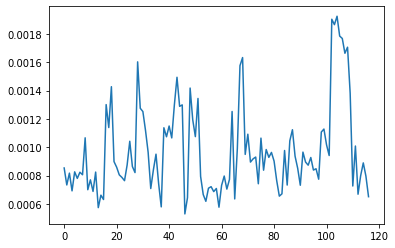

In [38]:
import matplotlib.pyplot as plt
plt.plot(as_imgwise2.numpy())

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

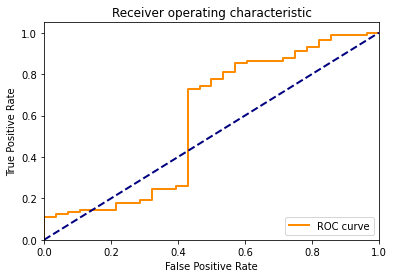

In [55]:
# Image-wise

true_pxl_labels = [1 for i in range(36)] + [0 for i in range(28)] + [1 for i in range(53)]
predicted_labels = list(as_imgwise2.numpy())
fpr, tpr, thresholds = roc_curve(true_pxl_labels, predicted_labels)

plt.figure();
plt.plot(fpr, tpr,color="darkorange", lw=2, label="ROC curve");
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--");
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");
plt.title("Receiver operating characteristic");
plt.legend(loc="lower right");

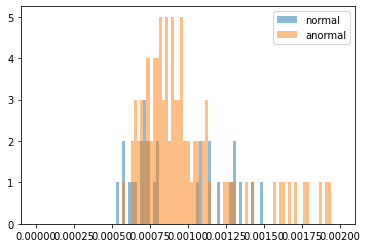

In [56]:
# Histogrammes
predicted_labels = list(as_imgwise2.numpy())
predicted_labels_normal = predicted_labels[36:64]
predicted_labels_anormal = predicted_labels[:36] + predicted_labels[64:]

bins = np.linspace(0, .002, 100)
plt.hist(predicted_labels_normal, bins, alpha=0.5, label='normal');
plt.hist(predicted_labels_anormal, bins, alpha=0.5, label='anormal');
plt.legend(loc='upper right');

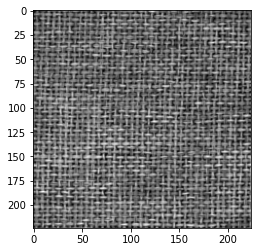

In [57]:
plt.imshow(inputs2[39].mean(0), cmap="gray");

### Pixel-wise

In [43]:
# Pixel-wise

# from df_masks, load the masks on numpy
# array (images, largeur, hauteur)
# check if no transposition
# fct ravel

# fpr, tpr, thresholds = roc_curve(true_pxl_labels, predicted_labels)

# plt.figure()
# plt.plot(fpr, tpr,color="darkorange", lw=2, label="ROC curve")
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver operating characteristic")
# plt.legend(loc="lower right")
# plt.show()

C:\Users\Public\Documents\DIMA\fcdd\data\datasets\mvtec\carpet\ground_truth\color\000_mask.png


(224, 224)

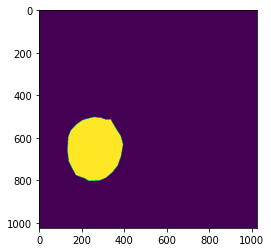

In [44]:
from matplotlib import image

# for path in list(df_masks["mask_path"].to_numpy()):
#     img = image.imread(path)
#     img.resize(224,224)
#     img.shape
#     img
path = list(df_masks["mask_path"].to_numpy())[0]
print(path)
img = image.imread(path)
plt.imshow(img)
img.resize(224,224)
# plt.imshow(img)
img.shape

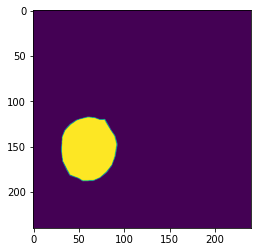

In [45]:
# Test for resize
from matplotlib import image
path = list(df_masks["mask_path"].to_numpy())[0]
img = image.imread(path)
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
img_resized = resize(img, (240, 240),
                       anti_aliasing=True)
plt.imshow(img_resized)

In [46]:
from matplotlib import image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

masks_anormal = []

for path in list(df_masks["mask_path"].to_numpy()):
    img = image.imread(path)
    img_resized = resize(img, (224, 224),
                       anti_aliasing=True)
    masks_anormal.append(img_resized)


In [47]:
masks_normal = []
for i in range(28):
    mask = np.zeros((224,224))
    masks_normal.append(mask)

In [48]:
all_masks_array = np.array(masks_anormal[:36]+masks_normal+masks_anormal[36:])

In [49]:
all_masks_array = all_masks_array.astype(int)

In [50]:
predicted_labels = as_pixelwise2.numpy()
# predicted_labels_selected = np.delete(predicted_labels, slice(36,36+28), 0)
predicted_labels.shape
all_masks_array.shape

(117, 224, 224)

(117, 224, 224)

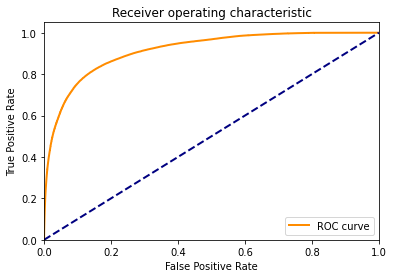

In [51]:
# Plot ROC AUC

fpr, tpr, thresholds = roc_curve(all_masks_array.ravel(), predicted_labels.ravel())

plt.figure();
plt.plot(fpr, tpr,color="darkorange", lw=2, label="ROC curve");
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--");
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");
plt.title("Receiver operating characteristic");
plt.legend(loc="lower right");

In [52]:
# predicted_labels_selected = np.delete(predicted_labels, slice(36,36+28), 0)
predicted_labels_anormal = predicted_labels.ravel()[all_masks_array.ravel().astype(bool)]
predicted_labels_normal = predicted_labels.ravel()[~all_masks_array.ravel().astype(bool)]
predicted_labels_anormal.shape
predicted_labels_normal.shape

(69119,)

(5801473,)

In [53]:
# Ravel method
as_pixelwise_ravel = as_pixelwise.ravel()
as_pixelwise_ravel.shape

torch.Size([5870592])

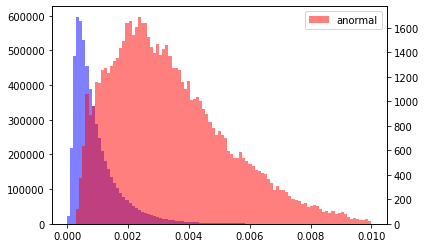

In [54]:
# Histograms

# predicted_labels_selected = np.delete(predicted_labels, slice(36,36+28), 0)
# predicted_labels_normal = predicted_labels[36:36+28,:,:]
predicted_labels_anormal = predicted_labels.ravel()[all_masks_array.ravel().astype(bool)]
predicted_labels_normal = predicted_labels.ravel()[~all_masks_array.ravel().astype(bool)]

bins = np.linspace(0, .01, 100)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.hist(predicted_labels_normal, bins, alpha=.5, label='normal', color='b');
ax2.hist(predicted_labels_anormal, bins, alpha=.5, label='anormal', color='r');
plt.legend(loc='upper right');